In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import time
import math

from torch.utils.data import DataLoader

import torch
import torch.nn as nn

%matplotlib inline

torch.manual_seed(1)
np.random.seed(1)
random.seed(1)

gpu = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = gpu

import sys
# Get the previous folder and append it to sys.path
PATH = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PATH)

from config import DATAFOLDER

In [2]:
src_domain = 'FSeg'
tgt_domain = 'Thebe'

da_method = 'DANN'
w_domain = 0.5

# data
red = 0 # reduction factor
n_imgs = 8000  # {3200, 6400} max: 49770
bs = 16 # batch size
type_aug = "type1" # type0, type1
nw = 2 # num_workers

# model
net = "dexined" # unet2d / dexined
f = 16 # filters on first layer
branch = 'blk4' 

# training
optimizer = 'Adam'
lr = 1e-4
lr_adjust = False
epochs = 10 # 100
loss = 'bdcn_grl'

# -----------------------------------------------------------------------------
config_keys = [k for k,v in globals().items() if not k.startswith('_') and isinstance(v, (int, float, bool, str))]
config = {k: globals()[k] for k in config_keys} # will be useful for logging

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Data

In [4]:
from dataloaders import ThebeGenerator, FaultSeg2DGenerator

In [5]:
dataset = 'Thebe'
DATAPATH = os.path.join(DATAFOLDER, dataset)

ps = '256to128' # patch size
step = 3 # step size

DATAPATH_TH_SRC = os.path.join(DATAPATH, 'Patches2D', 'src_ps{}_step{}'.format(ps, step) )
DATAPATH_TH_TGT = os.path.join(DATAPATH, 'Patches2D', 'tgt_ps{}_step{}'.format(ps, step) )

train_gen_TH = ThebeGenerator(DATAPATH_TH_TGT, "train", red=red, n_imgs=n_imgs, aug=type_aug)
val_gen_TH = ThebeGenerator(DATAPATH_TH_SRC, "val", red=red, n_imgs=n_imgs)
len(train_gen_TH.list_IDs) # max. 497700

8000

In [6]:
dataset = 'FaultSeg3D'
DATAPATH_FS = os.path.join(DATAFOLDER, dataset)

train_gen_FS = FaultSeg2DGenerator(DATAPATH_FS, "train", red=red, n_imgs=n_imgs, aug=type_aug)
val_gen_FS = FaultSeg2DGenerator(DATAPATH_FS, "val", red=red, n_imgs=n_imgs)
len(train_gen_FS.list_IDs) # 51200

8000

In [7]:
train_tgt = DataLoader(dataset=train_gen_TH, batch_size=bs, shuffle=True, drop_last=True, num_workers=nw)
val_tgt = DataLoader(dataset=val_gen_TH, batch_size=bs, shuffle=False, drop_last=True, num_workers=nw)

train_src = DataLoader(dataset=train_gen_FS, batch_size=bs, shuffle=True, drop_last=True, num_workers=nw)
val_src = DataLoader(dataset=val_gen_FS, batch_size=bs, shuffle=False, drop_last=True, num_workers=nw)

## Modeling

In [8]:
from models.dexined_dann import DexiNed
from loss import bdcn_loss2

model = DexiNed(filters=f, branches=branch.split(',')).to(device)

In [9]:
opt = torch.optim.Adam(model.parameters(), lr=lr)

criterion = bdcn_loss2
criterion_disc = nn.BCELoss()

## Training

In [10]:
from metrics import *

In [11]:
# saved_name = wandb.run.id
# saved_path = os.path.join(PATH, 'res', '{}.pt'.format(saved_name))
# wandb.config.update({"saved_path": saved_name})

saved_path = "delete.pt"

stopPatience = 10
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', factor=0.1, patience=stopPatience//2, verbose=True)
saved_path

'delete.pt'

In [12]:
def process(load_src, load_tgt, model, phase='train', opt=None, epoch=0):

    task_loss_ = 0.0
    src_loss_domain_ = 0.0
    tgt_loss_domain_ = 0.0
    domain_loss_ = 0.0
    
    iou_ = 0.0
    iou_tgt_ = 0.0
    iou_tgt = 0.0 # NO BORRAR
    acc_src_ = 0.0
    acc_tgt_ = 0.0
    
    if phase=='train':
        model.train()  
    else:
        model.eval()
        
    len_data = min(len(load_src), len(load_tgt))
    
    for step_, ((x_src, y_src), (x_tgt, y_tgt)) in enumerate(zip(load_src, load_tgt)):
        
        # compute lambda
        p = float(step_ + epoch * len_data) / (epochs * len_data)
        lamb = 2. / (1. + np.exp(-10 * p)) - 1
        
        if phase=='val':
            lamb = 0
        
        # prepare domain label
        size_src = len(x_src)
        size_tgt = len(y_src)
        label_src = torch.zeros(size_src).float().to(device)  # source 0
        label_tgt = torch.ones(size_tgt).float().to(device)  # target 1
        
        # make images variable
        x_src = x_src.float().to(device=device)
        y_src = y_src.to(device=device).unsqueeze(1)
        x_tgt = x_tgt.float().to(device=device)
        y_tgt = y_tgt.to(device=device).unsqueeze(1)        
        
        # train on source domain
        src_class_output, src_domain_output = model(x_src, alpha=lamb)
#         src_loss_class = criterion(src_class_output, y_src)
        src_loss_class = criterion(src_class_output[-1], y_src, 0.5) + criterion(src_class_output[2], y_src, 0.5) # bdcn_loss
        src_loss_class = src_loss_class / 5. # just to keep in a similar range than BCE
        
        src_loss_domain = criterion_disc(src_domain_output, label_src.unsqueeze(1))
        
        
        
        # train on target domain
        tgt_class_output, tgt_domain_output = model(x_tgt, alpha=lamb)
        
        tgt_loss_domain = criterion_disc(tgt_domain_output, label_tgt.unsqueeze(1))
        
        
        domain_loss = (src_loss_domain + tgt_loss_domain)*w_domain
        total_loss = src_loss_class + domain_loss
        
        if phase=='train':
            # calculate the gradients
            opt.zero_grad()
            total_loss.backward()

            # update weigths
            opt.step()
        
        ## compute loss
        task_loss_ += src_loss_class.item()
        src_loss_domain_ += src_loss_domain.item()
        tgt_loss_domain_ += tgt_loss_domain.item()
        domain_loss_ += domain_loss.item()
        
        ## compute metrics
        src_class_output = (src_class_output[-1] + src_class_output[2] + src_class_output[3])/3.
        src_class_output = torch.nn.Sigmoid()(src_class_output)
        pred_ = (src_class_output > 0.5).float() 
        iou_ += compute_iou(pred_.squeeze(1), y_src.squeeze(1))
        
        if phase=='val':
            tgt_class_output = (tgt_class_output[-1] + tgt_class_output[2] + tgt_class_output[3])/3.
            tgt_class_output = torch.nn.Sigmoid()(tgt_class_output)
            pred_2 = (tgt_class_output > 0.5).float()
            iou_tgt_ += compute_iou(pred_2.squeeze(1), y_tgt.squeeze(1))
 
        pred_src = (src_domain_output > 0.5).float()
        acc_src_ += pred_src.squeeze(1).eq(label_src.data).float().mean().item()
        
        pred_tgt = (tgt_domain_output > 0.5).float()
        acc_tgt_ += pred_tgt.squeeze(1).eq(label_tgt.data).float().mean().item()
        
        
    task_loss = task_loss_/(step_+1)
    src_loss_domain = src_loss_domain_/(step_+1)
    tgt_loss_domain = tgt_loss_domain_/(step_+1)
    domain_loss = domain_loss_/(step_+1)
    
    iou = iou_/(step_+1)
    if phase=='val':
        iou_tgt = iou_tgt_/(step_+1)
    acc_src = acc_src_/(step_+1)
    acc_tgt = acc_tgt_/(step_+1)
    
    if phase=='val':
        scheduler.step(task_loss)
        
    return task_loss, src_loss_domain, tgt_loss_domain, domain_loss, iou, iou_tgt, acc_src, acc_tgt

In [13]:
min_valid_loss = np.inf
max_valid_vl = -np.inf
n_patience = 0
t_start = time.time()
t_start_total = time.time()

for ep in range(epochs):
    
    task_loss_tr, src_loss_domain_tr, tgt_loss_domain_tr, domain_loss_tr, iou_src_tr, iou_tgt_tr, acc_src_tr, acc_tgt_tr = \
    process(train_src, train_tgt, model, phase='train', opt=opt, epoch=ep)

    with torch.no_grad():
        task_loss_vl, src_loss_domain_vl, tgt_loss_domain_vl, domain_loss_vl, iou_src_vl, iou_tgt_vl, acc_src_vl, acc_tgt_vl = \
        process(val_src, val_tgt, model, phase='val', epoch=ep)
        
    t_ = time.time()-t_start
    
#     wandb.log({
#         "train/epoch/time": t_,
#         "train/epoch/step": ep+1,
        
#         "train/epoch/task_loss": task_loss_tr,
#         "train/epoch/domain_loss": domain_loss_tr,
#         "train/epoch/domain_loss/src": src_loss_domain_tr,
#         "train/epoch/domain_loss/tgt": tgt_loss_domain_tr,
#         "train/epoch/iou/src": iou_src_tr,
# #         "train/epoch/iou/tgt": iou_tgt_tr,
#         "train/epoch/acc/src": acc_src_tr,
#         "train/epoch/acc/tgt": acc_tgt_tr,

#         "val/epoch/task_loss": task_loss_vl,
#         "val/epoch/domain_loss": domain_loss_vl,
#         "val/epoch/domain_loss/src": src_loss_domain_vl,
#         "val/epoch/domain_loss/tgt": tgt_loss_domain_vl,
#         "val/epoch/iou/src": iou_src_vl,
#         "val/epoch/iou/tgt": iou_tgt_vl,
#         "val/epoch/acc/src": acc_src_vl,
#         "val/epoch/acc/tgt": acc_tgt_vl,
        
#     })
    
    
    print('Epoch {}:   {:.1f}s - task_loss: {:.4f} - domain_loss: {:.4f} - acc_src: {:.4f} - acc_tgt: {:.4f}'.format(ep+1, t_, task_loss_tr, domain_loss_tr, acc_src_tr, acc_tgt_tr))
    print('                   val_task_loss: {:.4f} - val_domain_loss: {:.4f} - val_acc_src: {:.4f} - val_acc_tgt: {:.4f}'.format(task_loss_vl, domain_loss_vl, acc_src_vl, acc_tgt_vl))
    print('')
    
    if (ep+1)%10 == 0:
        torch.save(model.state_dict(), saved_path)
    
#     if min_valid_loss > loss_vl:
#         print(f'val_loss improved from {min_valid_loss:.6f} to {loss_vl:.6f} , saving model\n')
#         min_valid_loss = loss_vl
#         torch.save(model.state_dict(), saved_path)
#         n_patience=0
#     else:
#         print(f'val_loss did not improve from {min_valid_loss:.6f}\n')
#         n_patience+=1
#         if n_patience==stopPatience:
#             print('Epoch {}:   early stopping'.format(ep+1))
#             break
            
    t_start = time.time()
    
t_total = time.time() - t_start_total

Epoch 1:   153.0s - task_loss: 0.2799 - domain_loss: 0.6989 - acc_src: 0.5229 - acc_tgt: 0.4684
                   val_task_loss: 0.2426 - val_domain_loss: 0.6935 - val_acc_src: 0.4322 - val_acc_tgt: 0.6484

Epoch 2:   159.3s - task_loss: 0.2257 - domain_loss: 0.6973 - acc_src: 0.4650 - acc_tgt: 0.5078
                   val_task_loss: 0.2152 - val_domain_loss: 0.6759 - val_acc_src: 0.5840 - val_acc_tgt: 0.6770

Epoch 3:   164.0s - task_loss: 0.2065 - domain_loss: 0.6965 - acc_src: 0.4657 - acc_tgt: 0.5028
                   val_task_loss: 0.2042 - val_domain_loss: 0.6733 - val_acc_src: 0.5739 - val_acc_tgt: 0.8624

Epoch 4:   167.2s - task_loss: 0.1967 - domain_loss: 0.6956 - acc_src: 0.4706 - acc_tgt: 0.5329
                   val_task_loss: 0.1976 - val_domain_loss: 0.6892 - val_acc_src: 0.7477 - val_acc_tgt: 0.3620

Epoch 5:   168.9s - task_loss: 0.1889 - domain_loss: 0.6946 - acc_src: 0.4796 - acc_tgt: 0.4941
                   val_task_loss: 0.1871 - val_domain_loss: 0.6845 - val

In [14]:
t_total/60, ep

(28.148355134328206, 9)

## Validation

In [15]:
model.load_state_dict(torch.load(saved_path))
model.eval()
print()

In [16]:
for idx, (x_tgt, y_tgt) in enumerate(val_tgt):
    print(x_tgt.shape, y_tgt.shape)
    break

torch.Size([16, 1, 128, 128]) torch.Size([16, 128, 128])


In [17]:
y_tgt_probs = model(x_tgt.float().to(device), alpha=0)[0] #.cpu().detach().numpy()
y_tgt_prob = (y_tgt_probs[-1] + y_tgt_probs[2] + y_tgt_probs[3])/3
y_tgt_prob = torch.nn.Sigmoid()(y_tgt_prob).cpu().detach().numpy()
y_tgt_pred = np.where(y_tgt_prob[:,0] >= 0.5, 1, 0)
y_tgt_prob.shape, y_tgt_pred.shape

((16, 1, 128, 128), (16, 128, 128))

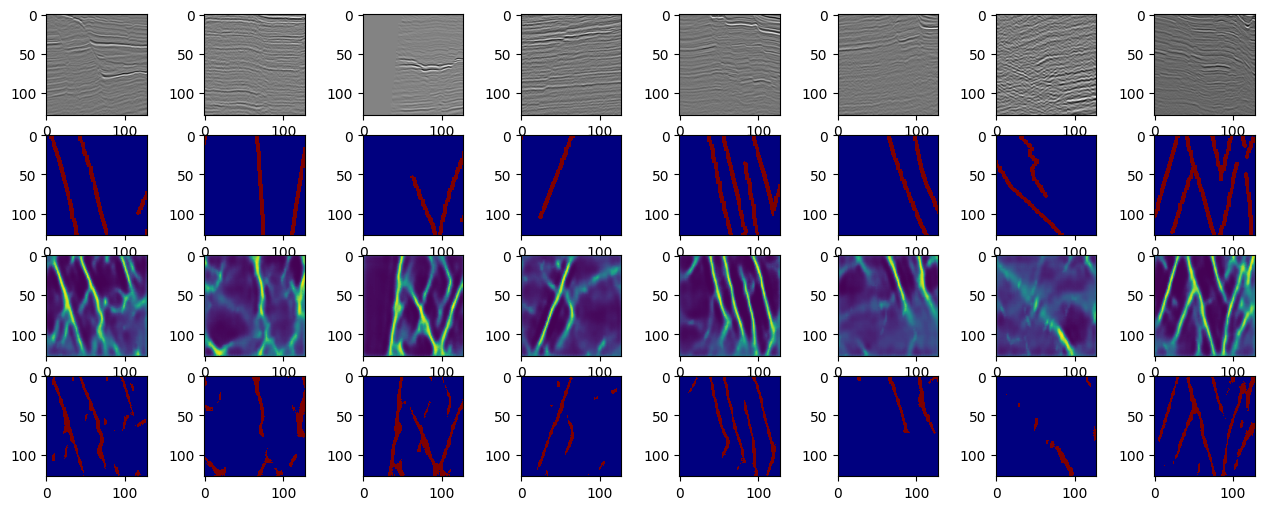

In [18]:
fig, axes = plt.subplots(4, 8, figsize=[16,6])

for i in range(8):
    axes[0, i].imshow(x_tgt[i,0], cmap="gray")
    axes[1, i].imshow(y_tgt[i], cmap="jet", interpolation="nearest")
    axes[2, i].imshow(y_tgt_prob[i,0])
    axes[3, i].imshow(y_tgt_pred[i], cmap="jet", interpolation="nearest")
    
# wandb.log({"valid/imgs_tgt": fig})

### Metrics

In [19]:
import pandas as pd
from tqdm import tqdm

In [21]:
val_tgt = DataLoader(dataset=val_gen_TH, batch_size=128, shuffle=False, drop_last=True,
                     num_workers=4)

y_true_list = []
y_prob_list = []
for x_tgt, y_tgt in tqdm(val_tgt):
    y_probs = model(x_tgt.float().to(device), alpha=0)[0]
    y_prob = (y_probs[-1] + y_probs[2] + y_probs[3])/3.
    y_prob = torch.nn.Sigmoid()(y_prob).cpu().detach().numpy() # probs
    
    y_true_list.append(y_tgt)
    y_prob_list.append(y_prob[:,0])
    
y_true_total = np.vstack(y_true_list)  #.ravel()
y_prob_total = np.vstack(y_prob_list) #.ravel()
y_pred_total = np.where(y_prob_total >= 0.5, 1, 0)

y_true_total.shape

100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.10it/s]


(4352, 128, 128)

In [22]:
th_range = np.arange(0, 1, 0.02)
metrics_list = []

y_true = torch.tensor(y_true_total, dtype=torch.float32).to(device)
y_prob = torch.tensor(y_prob_total, dtype=torch.float32).to(device)

for th in th_range:
    pr, re, f1 = binary_classification_metrics(y_prob, y_true, th)
    metrics_list.append([pr, re, f1])

In [23]:
df = pd.DataFrame(np.array(metrics_list)).reset_index(drop=True)
df.columns = ['precision', 'recall', 'f1_score']
df.index = th_range

In [24]:
f1_ = df.loc[0.5]['f1_score']
# wandb.log({"valid/f1_tgt": f1_})

In [25]:
iou = compute_iou((y_prob > 0.5).float(), y_true.contiguous())
# wandb.log({"valid/iou_tgt": iou})

In [26]:
print("Original:  IoU: {:.4f}   F1-score: {:.4f}".format(iou, f1_))

Original:  IoU: 0.2614   F1-score: 0.4145


### New Metrics

In [27]:
getNewMetrics(y_true_total, y_pred_total, sigma=1) #, wandb=wandb)

299it [00:00, 491.32it/s]C:\Users\Usuario\Documents\Mestrado\Tesis\src\UDAforFaultDetection\metrics.py:157: RuntimeWarning: divide by zero encountered in scalar divide
  iou = 1/(1/recall+1/precision-1)
C:\Users\Usuario\Documents\Mestrado\Tesis\src\UDAforFaultDetection\metrics.py:158: RuntimeWarning: divide by zero encountered in scalar divide
  f1 = 2/(1/recall+1/precision)
4352it [00:08, 534.12it/s]

With Sigma=1:  IoU: 0.3252   F1-score: 0.4660


In [28]:
getNewMetrics(y_true_total, y_pred_total, sigma=4) #, wandb=wandb)

4352it [00:07, 590.79it/s]

With Sigma=4:  IoU: 0.4974   F1-score: 0.6365


In [29]:
getNewMetrics(y_true_total, y_pred_total, sigma=7) #, wandb=wandb)

4352it [00:07, 589.19it/s]

With Sigma=7:  IoU: 0.5726   F1-score: 0.7037
